In [2]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [3]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

In [4]:
import warnings 
warnings.filterwarnings('ignore')

# Question 1

In [6]:
import pandas as pd

state_name = "Utah"

# SQL query
query = """
SELECT p.year, p.pop
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = %s
ORDER BY p.year;
"""

# Load into pandas for convenience
df = pd.read_sql(query, conn, params=(state_name,))
print(df)

    year      pop
0   2005  2427350
1   2006  2550063
2   2007  2645330
3   2008  2736424
4   2009  2784572
5   2010  2776469
6   2011  2817222
7   2012  2855287
8   2013  2900872
9   2014  2942902
10  2015  2995919
11  2016  3051217
12  2017  3101833
13  2018  3161105
14  2019  3205958


In [7]:
import matplotlib.pyplot as plt

In [8]:
! pip install jupyter-ai-magics[all] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.11.10 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


In [9]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [10]:
%load_ext jupyter_ai_magics

In [21]:
%%ai gpt4 -f code

using all python, Write an SQL query to retrieve the yearly population for your state using fips = '49', compute growth rate in SQL, and loads the results and create a
line chart with the growth rate, the Chart must include the state name in the title.


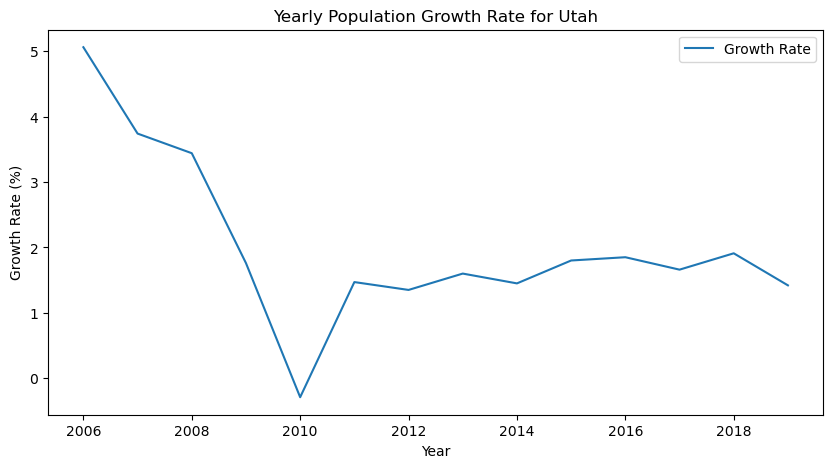

In [30]:
# Query
query = """
SELECT 
    n.name,
    p.year,
    p.pop,
    ROUND(
        ( (p.pop - LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year))::numeric 
          / LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year) ) * 100, 2
    ) AS growth_rate
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = %s
ORDER BY p.year;
"""

# Read query into dataframe
state_name = "Utah"

q1_df = pd.read_sql_query(query, conn, params=(state_name,))

# Plot
plt.figure(figsize=(10,5))
plt.plot(q1_df['year'], q1_df['growth_rate'], label = "Growth Rate")
plt.title('Yearly Population Growth Rate for Utah')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.show()

The graph shows that the population growth rate was very high starting in 2006 and dropped significantly until 2010, then it steadily but slowly increased until 2018 and finally dropped a little in 2019.

In [38]:
%%ai gpt4 -f code
Using python exclusively Write an SQL query to join the income and population tables for your state,
selecting values for all years

In [42]:
# SQL Query
query = """
SELECT 
    i.year, 
    i.income, 
    p.pop
FROM
    income i
JOIN
    population p
    ON i.year = p.year AND i.fips = p.fips
WHERE 
    i.fips = '49'
ORDER BY i.year;
"""

# Execute the SQL query
cur.execute(query)

# Fetch all records from the database execution
results = cur.fetchall()


In [43]:
%%ai gpt4 -f code
create a dual-axis chart:
o X-axis = year
o Left Y-axis = population (line)
o Right Y-axis = median household income (bar or line, different color)
• Chart must include the state name (Utah) in the title.




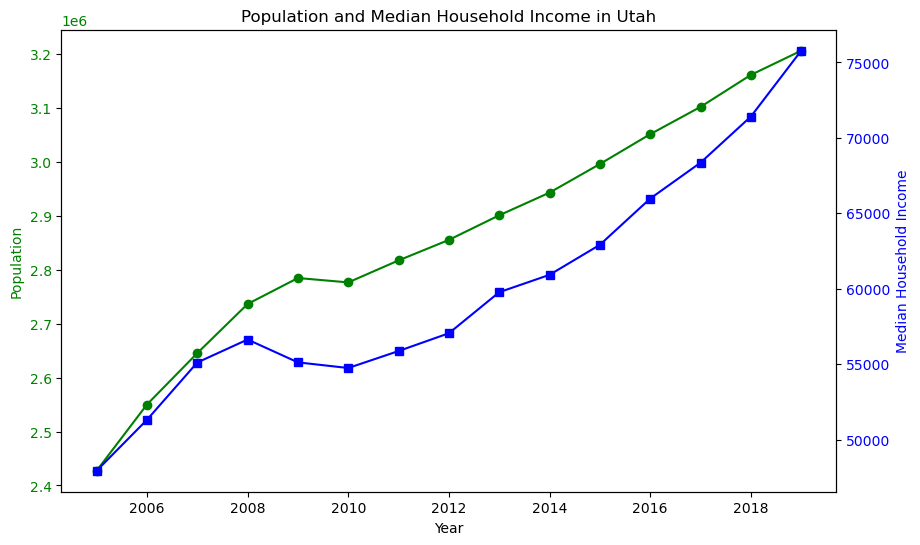

In [44]:
import matplotlib.pyplot as plt

# Assuming the data from the query is stored in a pandas DataFrame named 'df'

fig, ax1 = plt.subplots(figsize=(10,6))

# Set the x-axis as the year
x_data = df['year']

# Create population line plot on first y-axis
ax1.plot(x_data, df['pop'], color='g', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Create median household income plot on the second y-axis
ax2 = ax1.twinx()
ax2.plot(x_data, df['income'], color='b', marker='s')
ax2.set_ylabel('Median Household Income', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Set chart title including state name
state_name = "Utah"
plt.title(f'Population and Median Household Income in {state_name}')

# Show the plot
plt.show()


The population and the median household income move almost in parallel to each other. When the  population increases, so does median household income and vice versa.

# Question 3

Which year in Utah saw the largest increase in median household income?

In [26]:
query = """
SELECT i.year, i.income
FROM income i
JOIN name n ON i.fips = n.fips
WHERE n.name = 'Utah'
ORDER BY i.year;
"""

q3_df = pd.read_sql(query, conn) 

In [34]:
%%ai gpt4 -f code 
using exclusively python code, do the following: generate Python code for visualization that shows the increase in income for the query in {q3_df} (line chart, bar chart, or
other appropriate type). The chart must include the state name in the title. my sate name is 'Utah' 

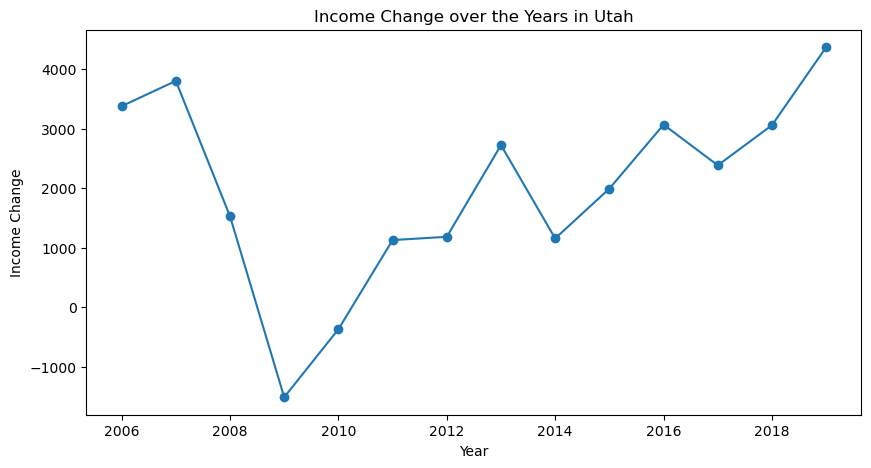

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'income': [47934, 51309, 55109, 56633, 55117, 54744, 55869, 57049, 59770, 60922, 62912, 65977, 68358, 71414, 75780],
    'income_change': [None, 3375.0, 3800.0, 1524.0, -1516.0, -373.0, 1125.0, 1180.0, 2721.0, 1152.0, 1990.0, 3065.0, 2381.0, 3056.0, 4366.0]
}

df = pd.DataFrame(data)

plt.figure(figsize=[10,5])
plt.plot(df['year'], df['income_change'], marker='o')
plt.title('Income Change over the Years in Utah')
plt.xlabel('Year')
plt.ylabel('Income Change')
plt.show()

The graph shows the change in median household income from year to year. it shows that the not just income as a whole but the change in income has been increasing since 2009.